In [22]:
%reload_ext autoreload
%autoreload 2 
%matplotlib inline

#2 relaod all modules automaticaly

from dataset import SignLanguageDataset, split_tensor_dataset, read_tensor_dataset
from utils import plot_dataset
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import v2
import torch
import tqdm

from dataset import max_channel


# Load old annotated data

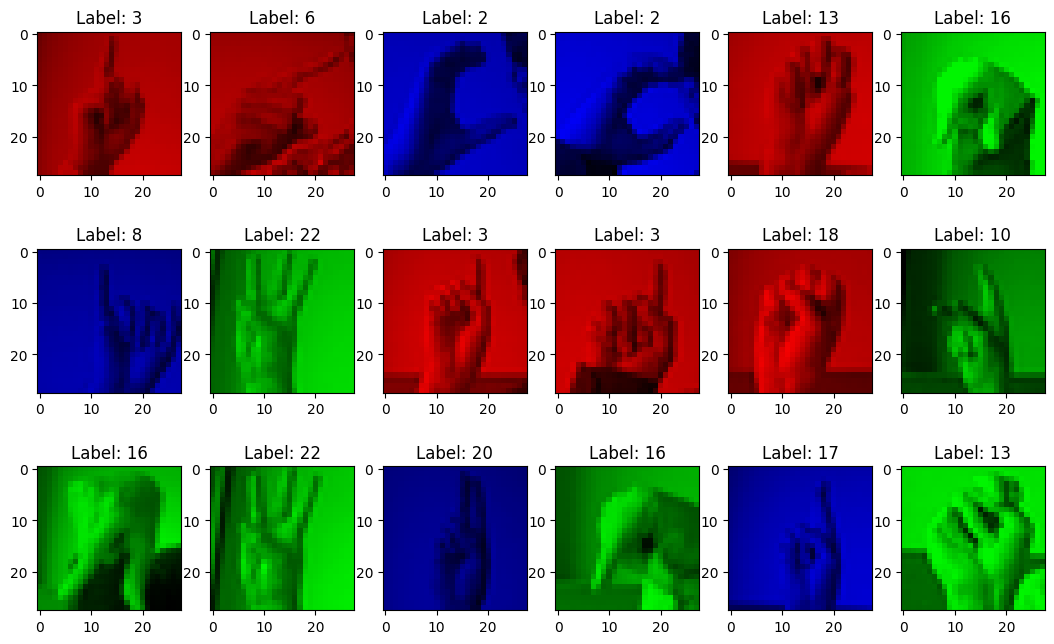

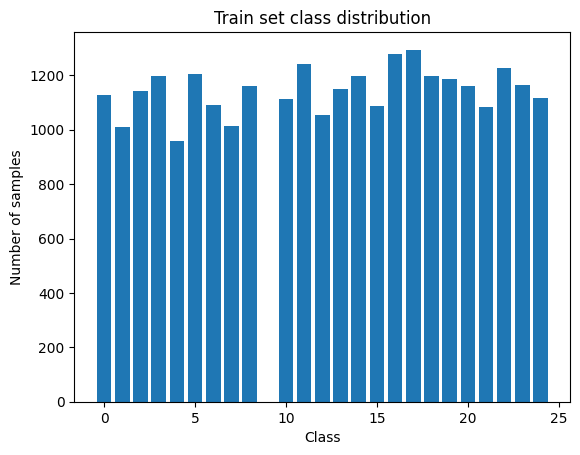

In [23]:
from collections import Counter
from matplotlib import pyplot as plt
raw_data = read_tensor_dataset(
    "data/thws-mai-idl-ss-25-sign-language/SignLanguage_kaggle/old_annotated.pth")

plot_dataset(raw_data)

# check class balance
_, labels = raw_data[:]
# Counter could't run on tensor becacuse tensor obj has different hash
counts = Counter([int(lb.item()) for lb in labels])

# Reuse the same counts mapping: keys are class IDs, values are sample counts
plt.bar(counts.keys(), counts.values())
# Label nine is missing

plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Train set class distribution")
plt.show()

Train data lenght: 19218
Val data lenght: 4118
Test data lenght: 4119


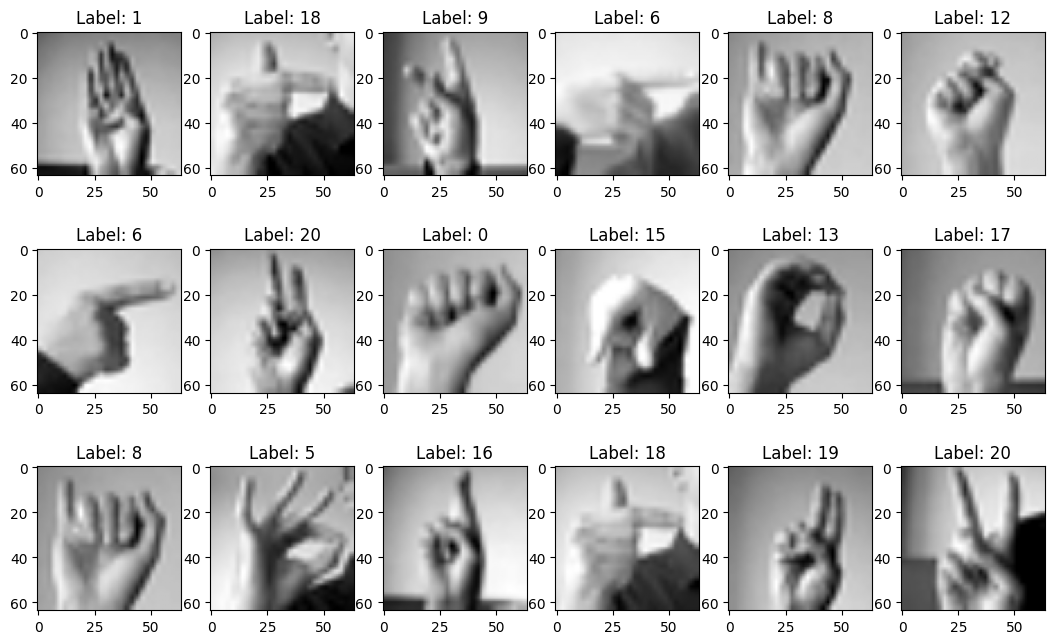

torch.Size([1, 1, 64, 64])


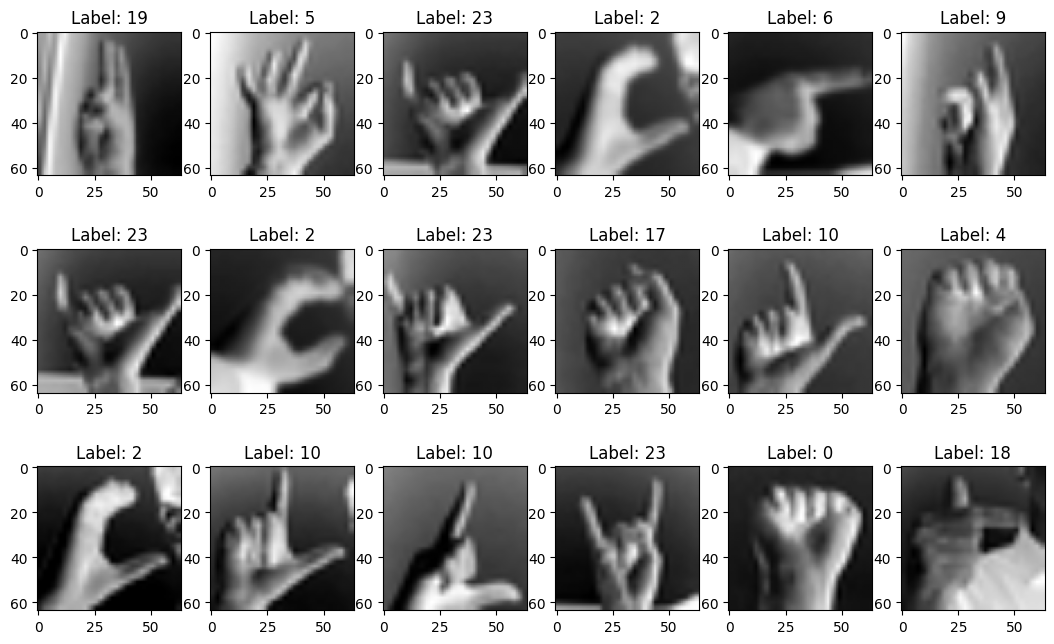

In [24]:
IMAGE_SIZE = 64
train_data, val_data, test_data = split_tensor_dataset(raw_data)

print(f"Train data lenght: {len(train_data)}")
print(f"Val data lenght: {len(val_data)}")
print(f"Test data lenght: {len(test_data)}")

transform = v2.Compose(
    [
        v2.Lambda(max_channel),
        v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    ]
)

train_dataset_unconverted = SignLanguageDataset(train_data, transform=transform)
plot_dataset(train_dataset_unconverted, cmap='gray')

transform = v2.Compose(
    [
        v2.Lambda(max_channel),
        v2.Lambda(lambda x: 1-x),
        v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    ]
)
train_dataset = SignLanguageDataset(train_data, transform=transform)

train_dataloader = iter(DataLoader(
    train_dataset, batch_size=1, shuffle=True))
# print(next(train_dataloader))
img, label = next(train_dataloader)
print(img.shape)

plot_dataset(train_dataloader, cmap='gray')

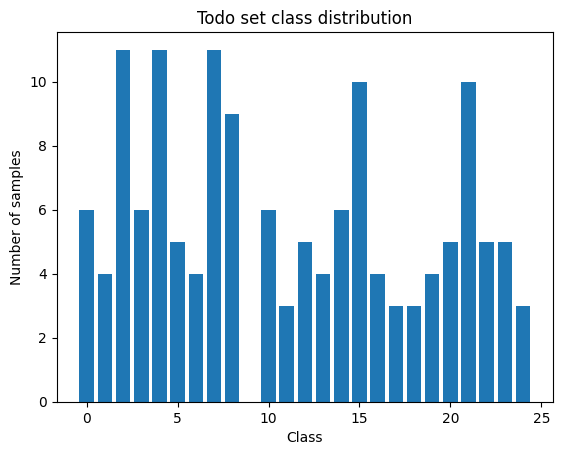

In [25]:
# Read todoexample, make sure the l"abels also didn't include 9
todo_example = read_tensor_dataset(
    "data/thws-mai-idl-ss-25-sign-language/SignLanguage_kaggle/todo_example.pth")

img, labels = todo_example[:]
todo_counts = Counter([int(lb.item()) for lb in labels])

# Reuse the same counts mapping: keys are class IDs, values are sample counts
plt.bar(todo_counts.keys(), todo_counts.values())
# Label nine is missing

plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Todo set class distribution")
plt.show()


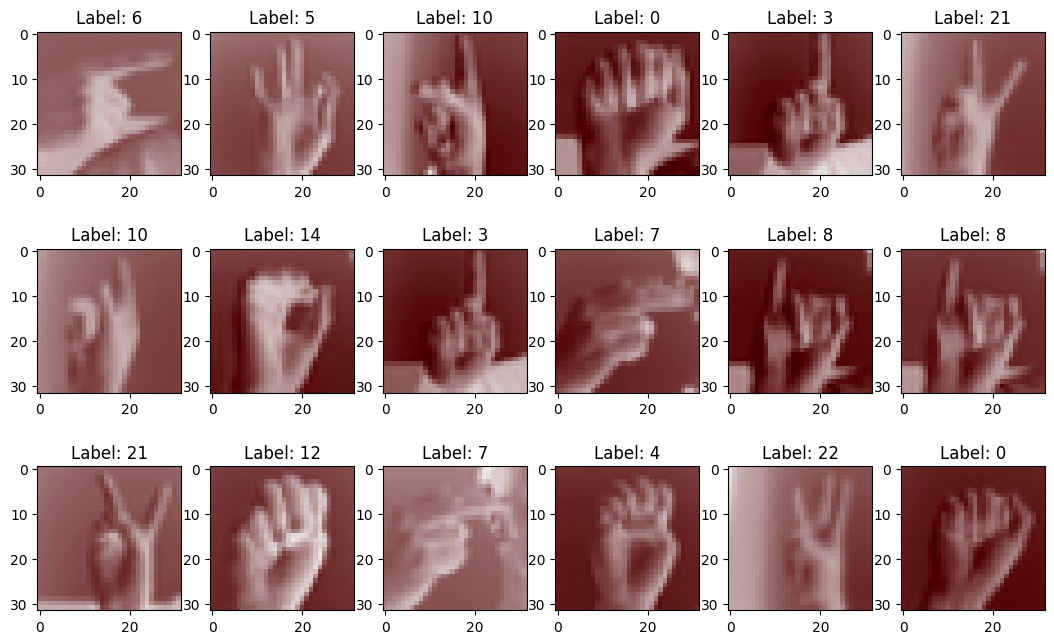

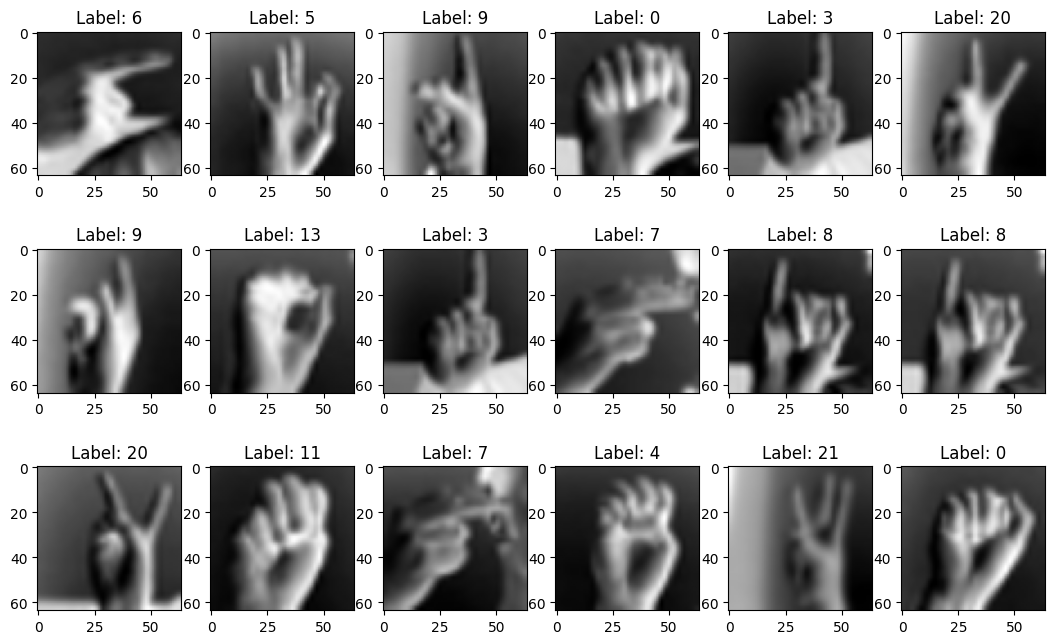

In [26]:

plot_dataset(todo_example)


todo_transform = v2.Compose(
    [
        v2.Grayscale(),
        v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    ]
)
tod_ex_dataset = SignLanguageDataset(
    todo_example, transform=todo_transform)

todo_ex_dataloader = iter(DataLoader(tod_ex_dataset))

plot_dataset(todo_ex_dataloader, cmap='gray')

tensor([0, 0, 0,  ..., 0, 0, 0])
torch.Size([1, 1, 64, 64])


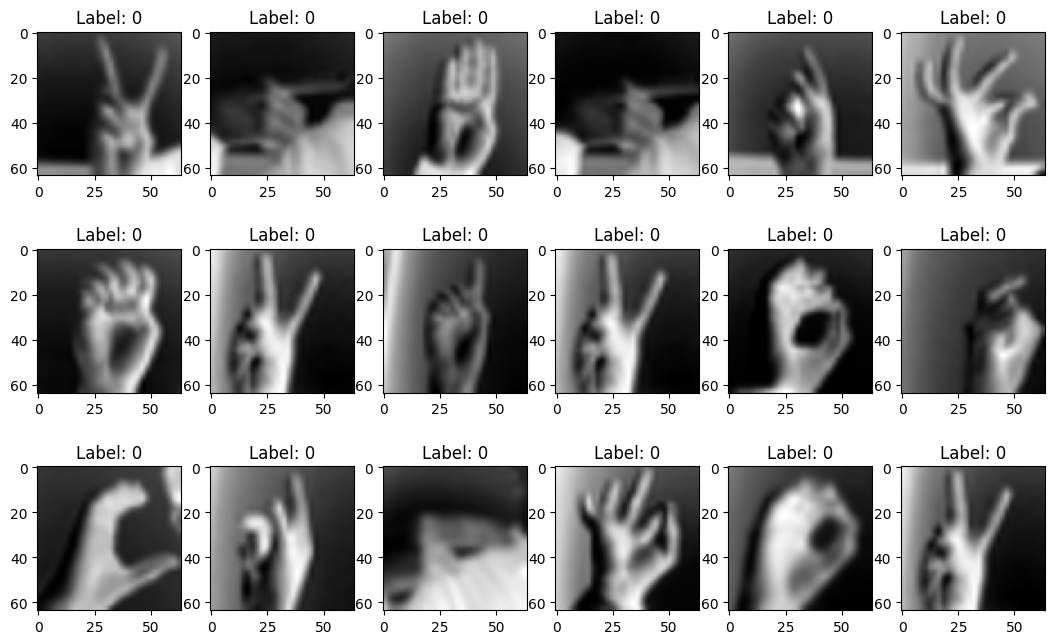

In [27]:
# Read todo, make sure the l"abels also didn't include 9
todo_data = read_tensor_dataset(
    "data/thws-mai-idl-ss-25-sign-language/SignLanguage_kaggle/todo.pth")

imgs, labels = todo_data[:]
print(labels)

tod_dataset = SignLanguageDataset(
    todo_data, transform=todo_transform)

todo_dataloader = iter(DataLoader(tod_dataset))

img, label = next(todo_dataloader)
print(img.shape)

plot_dataset(todo_dataloader, cmap='gray')

# Compute normalize parameter

In [28]:
def compute_mean_std(loader, n_channels=1):

    # n_channels = 1  # 如果是灰度图，改成1
    mean = torch.zeros(n_channels)
    std = torch.zeros(n_channels)
    total_pixels = 0

    for images, _ in tqdm.tqdm(loader):
        # 如果是灰度图像，images.shape = (B, 1, H, W)
        # 如果是彩色图像，images.shape = (B, 3, H, W)
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)  # [B, C, H*W]
        total_pixels += images.size(2) * batch_samples

        mean += images.sum(dim=[0, 2])  # sum over batch and pixels
        std += (images ** 2).sum(dim=[0, 2])

    mean /= total_pixels
    std = (std / total_pixels - mean ** 2).sqrt()

    return mean, std


train_mean, train_std = compute_mean_std(train_dataloader)
print(train_mean, train_std)

100%|█████████▉| 19199/19218 [00:02<00:00, 7200.25it/s]

tensor([0.3992]) tensor([0.1779])


In [29]:
# test data
todo_mean, todo_std = compute_mean_std(todo_dataloader, 1)
print(todo_mean, todo_std)

100%|█████████▉| 7010/7029 [00:00<00:00, 9910.79it/s] 

tensor([0.3896]) tensor([0.1755])
